# Программная реализация аналитической оценки

Подключение сторонних библиотек для моделирования

In [1]:
import numpy as np
import numpy.random as rand
import random # Для генерации одинакового шума
import scipy.linalg
import scipy as sp
from functools import reduce
import re

# Графический вывод
import matplotlib.pyplot as plt
plt.style.use("seaborn-darkgrid")
%matplotlib inline
from matplotlib.animation import FuncAnimation # Создание gif

# Интерактив
from ipywidgets import *

import os

## Генерация исследуемой функции

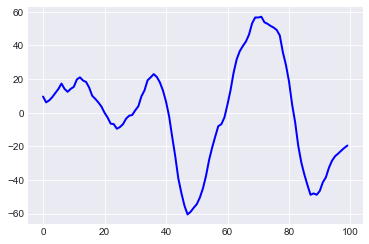

In [56]:
def get_B(N):
    """
    Функция для получения теплицевой матрицы B для сглаживания шума и 
    получения исследуемой функции.
    Входные параметры:
        N - размерность исследуемого сигнала
    """
    temp = np.zeros(N);
    b0 = np.arange(int(N/10), 0, -1) if N >= 10 else np.arange(N-2, 0, -1)
    temp[0:len(b0)] = b0
    B = np.array(scipy.linalg.toeplitz(temp)) 
    
    return B

def Xgeneration(N, B, M=1, m=0):
    """
    Функция для генерации случайных векторов
    Входные данные:
        N - число точек сигнала на отрезке [0,N]
        B - теплицева матрица
        m - мат. ожидание сигнала (производится z-преобразование, поэтому не используется)
        M - Число генерируемых сигналов
        
    """
    x = np.zeros((N,M))   # Создаем M сигналов
    
    # Генерируем белый шум
    mu = np.random.normal(0, 1, (N,M))
    # Применяем z-оценку (или нормализацию) к шуму
    mu = mu - np.mean(mu)
    # Получаем случайный сигнал с ковариациооной матрицей F
    x = B @ mu
    # Применяем z-оценку (или нормализацию) к сигналу
    x = x - np.mean(x) 
    
    # x = x - np.mean(x,axis=0) # Правильное приведение всех мат ожиданий к нулю рушит калибровку
    
    if M == 1: x = x[:,0] # Если это обычное измерение, то убираем одну размерность
        
    # Дисперсионная матрица для x
    F = B @ B.transpose()
    x0 = np.zeros(N) 
    x0[0:N-1] = x.mean(); 
    return [x, F, np.array(x0)]

# Генерируем исходный сигнал:
N = 100;  # Размерность неизвестного сигнала х
x, F, x0 = Xgeneration(N,get_B(N),1) 
plt.plot(np.arange(N), x, \
                  **{'linewidth' : 2, 'color' : 'blue', 'label' : 'x'});
#plt.savefig('signal.pdf')

## Эволюция сигнала

In [6]:
class Evolution:
    
    def __init__(self, x, transfer_evolution, 
                 conductivity_evolution, t0, T, J):
        self.transfer_evolution = transfer_evolution
        self.conductivity_evolution = conductivity_evolution
        
        if self.transfer_evolution:
            # Затухание происходит до значения мат ожидания
            self.transfer = ThermalTransfer(x, np.zeros(len(x)) + np.mean(x))  
            self.transfer.set_time_nodes(t0, T, J)
            self.transfer.signal_evolution()

        if self.conductivity_evolution:
            condact_koeff = 0.5
            #condact_koeff = 3 ##### Баг ли?
            j_l, j_r = 0, 99
            self.conduct = ThermalConductivity(condact_koeff, j_l, j_r)
            self.conduct.set_time_nodes(t0, T, J)
            self.conduct.signal_evolution(x)

    def set_time_nodes(self, t0, T, J):
        if J > 1:
            tau = (T - t0)/(J-1) # Временной шаг
        else:
            tau = 2*T
        self.t = np.arange(t0, T + tau/10, tau) # Временная сетка        
        
    def plot(self, x, J, N):
        if self.transfer_evolution or self.conductivity_evolution:
            for j in range(J):
                D_cond, D_tran = self.D_matrix(j, N)
                plt.plot(np.arange(N), D_cond @ D_tran @ x, \
                              **{'linewidth' : 2, 'color' : 'blue', 'label' : 'x'});
            
    def D_matrix(self, j, N):
        D = np.eye(N)
        
        D_cond = np.eye(N)
        D_tran = np.eye(N)
        if self.conductivity_evolution:
            D_cond = self.conduct.thermal_matrix(self.conduct.t[j], N)
        if self.transfer_evolution:
            D_tran = (np.eye(N)*self.transfer.weights[j])
        return D_cond, D_tran

In [7]:
class ThermalTransfer(Evolution):
    """Теплообмен со средой"""
    
    def __init__(self, x_init, x_final):
        self.x_init = x_init
        self.x_final = x_final
        
    def evolution_law(self, t, k=1):
        """Возвращает сигнал в момент времени t,
        эволюция котрого произошла по закону Ньютона
        """
        return self.x_final + np.exp(-k*t)*(self.x_init - self.x_final)
    
    
    def signal_evolution(self):
        """ Возвращает np.array, состоящий из сигналов
        начиная с момента времени t0 до T с числом интервалов J
        """
        N = np.size(self.x_init) # Размерность начального вектора
        J = np.size(self.t)
        x_t = np.zeros((J,N)) # Результирующий массив

        for j in range(J):
            x_t[j] = self.evolution_law(self.t[j])
        self.x_t = x_t
        
    @property
    def weights(self):
        w = ThermalTransfer(1, 0)
        w.t = self.t
        w.signal_evolution()
        return w.x_t

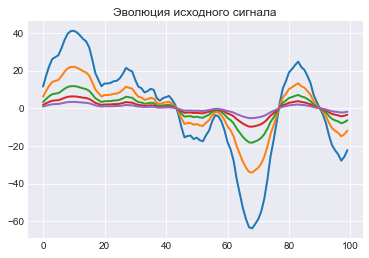

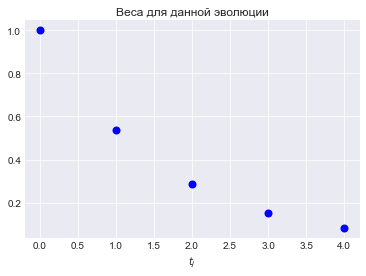

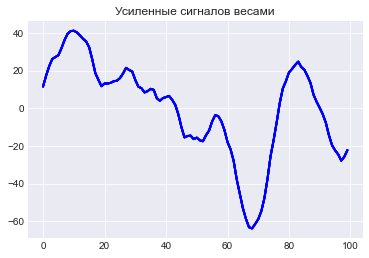

In [8]:
transfer = ThermalTransfer(x, np.zeros(N) + np.mean(x))  # Затухание происходит до значения мат ожидания
t0 = 0 # Начальный момент времени
T = 2.5 # Конечный момент времени
J = 5 # Число временных итераций
transfer.set_time_nodes(t0, T, J)
transfer.signal_evolution()
plt.figure()
plt.title('Эволюция исходного сигнала')
for j in range(J):
        plt.plot(np.arange(N), transfer.x_t[j], \
                      **{'linewidth' : 2, 'label' : 'x'});
#plt.savefig('transfer_evolution.pdf')

plt.figure()
plt.title('Веса для данной эволюции')
plt.xlabel('$t_j$')
plt.scatter(np.arange(J), transfer.weights, \
                      **{'linewidth' : 2, 'color' : 'blue', 'label' : 'x'});
#plt.savefig('weights_transfer_evolution.pdf')

plt.figure()
plt.title('Усиленные сигналов весами')
for j in range(J):
    D = np.linalg.inv(np.eye(N)*transfer.weights[j])
    plt.plot(np.arange(N), D@transfer.x_t[j], \
                  **{'linewidth' : 2, 'color' : 'blue', 'label' : 'x'});

In [9]:
class ThermalConductivity(Evolution):
    """Теплопроводность со стержнем"""
    
    def __init__(self, a, j_l, j_r):
        """ Инициализируем стержень с входными параметрами:
        а - коэфф. теплопроводности
        j_l, j_r - левая и правая границы области, в которой расположен сигнал
        """
        self.a = a
        self.area = [j_l, j_r]
 
    def signal_evolution(self, x):
        """ Возвращает np.array, состоящий из сигналов
        начиная с момента времени t0 до T с числом интервалов J
        """
        N = np.size(x) # Размерность начального вектора
        J = np.size(self.t)
        x_t = np.zeros((J,N)) # Результирующий массив

        for i in range(0,J):
            D = self.thermal_matrix(self.t[i], N)
            x_t[i,:] = D @ x
        self.x_t = x_t
        
    def thermal_matrix(self, t, N):
        """Функция возвращает матрицу для случая теплопроводности в стержне в момент времени t"""
        
        def grin_discrete(i,j, t, h=1):
            """
            Функция возвращает значение дискретизированной функции Грина
            """
            return h/(2 *a *np.sqrt(np.pi *t)) *np.exp( -1*(i-j) ** 2 *h ** 2/(4 *a**2 *t) )
        
        #m = self.area[1] - self.area[0] + 1
        m = N
        D = np.zeros((N,m))
        if t == 0:
            return np.eye(N)
        for j in range(0,m):
            D[0:N,j] = grin_discrete(np.array(range(0,N)),self.area[0] + j,t)
        return D

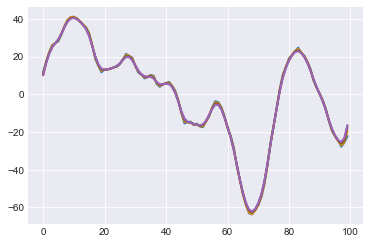

In [10]:
a = 0.5
j_l, j_r = 0, 99
t0 = 0.0
J = 5
T = 2.5
conduct = ThermalConductivity(a, j_l, j_r)
conduct.set_time_nodes(t0, T, J)
conduct.signal_evolution(x,)
plt.figure()
#plt.title('Эволюция исходного сигнала')
for j in range(J):
    plt.plot(np.arange(N), conduct.x_t[j], \
                **{'linewidth' : 2, 'label' : 'x'});
#plt.savefig('conduct_evolution.pdf')

## PSF

In [11]:
path = f"{os.getcwd()}\\PSF"
try:
    pass
    #os.mkdir(path)
except OSError:
    pass
    #os.mkdir(path)

In [12]:
class PSF:
    
    def __init__(self, profile=None, al=None, ar=None):
        """
        Входные аргументы:

        Тип профиля:
        profile ={'rectangular', 'triangular', ...
                  'parabolic','gaussian','exponential'};
        Левая и правая границы области:
        al < 0, ar > 0
        """
        self.profile = profile
        self.area = [al, ar]
    
    def set_profile(self, new_profile):
        self.profile = new_profile
        
    def set_area(self, new_area):
        self.area = new_area
    
    def get_PSF(self,):
        """
        Функция реализует выбор Point Spread Function.
        self.a - список коэффициентов а 
        """
        al, ar = self.area
        if self.profile == 'rectangular':
            self.a = np.ones(ar-al+1)
        elif self.profile == 'triangular':
            h1y = ar/np.abs(al)
            h2y = (ar + h1y)/(np.abs(ar) + 1)
            self.a = np.hstack((np.arange(0 + h1y, ar + h1y + h1y/10, h1y),
                           np.arange(ar + h1y -h2y, 0 + h2y/10,-h2y)))
        elif self.profile == 'parabolic':
            # Мы делаем две разные ветви параболы со своими коэфф
            # при х: ( y(ar) = k2*ar^2= y(al)=k1*al^2 )
            k = np.array([( (ar+1)/(al-1) ) ** 2, 1])
            a1 = k[0]*np.arange(al,0+1) ** 2
            a2 = k[1]*np.arange(0+1,ar+1) ** 2
            self.a = (ar + 1) ** 2 - np.hstack((a1,a2))
        elif self.profile == 'gaussian':
            # c = sigma
            c = (ar - al)/6
            w = 2*np.sqrt(2*np.log(2))*c
            self.a = np.exp(-4*np.log(2)*(np.arange(al,ar+1)-(ar + al)/2 )** 2/ w **2)
        elif self.profile == 'exponential': #(asymmetric)
            self.a = np.exp( -np.arange(al, ar + 1)/( (ar + np.abs(al))/4 ) )
        elif self.profile == 'random_noise':
            self.a = np.abs(np.random.normal(size=np.abs(al) + np.abs(ar) + 1))
        self.a /= np.sum(self.a)
     
    def random_area(self, shift = 10):
        """
        Функция получения границ PSF в случае рандомных измерений
        """
        al,ar = 100,0;
        while al >= ar:
            al = int(-1*np.floor(rand.sample()*5) - shift)
            ar = int(   np.floor(rand.sample()*5) + shift)
        return al, ar
        
    def plot(self,):
        al, ar = self.area
        plt.figure()
        plt.plot(np.arange(al-1,ar+2), np.hstack([0,self.a,0]))
        plt.title(f'Point Spread Function. Profile is {self.profile}')
        
        #plt.savefig(f'{os.getcwd()}\\PSF\\profile_{self.profile}.pdf')


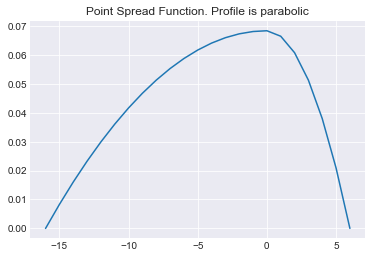

In [13]:
profiles =['rectangular','triangular','parabolic',\
    'gaussian','exponential','random_noise']
al, ar = -15, 5
#for profile in profiles:
profile = profiles[2]
psf = PSF(profile, al, ar)
psf.get_PSF()
psf.plot()

## Mode


In [14]:
class Mode:
    
    def __init__(self, mode):
        self.mode = mode
        
    def get_mode(self, profile, bs):
        """ 
        Функция реализует выбор режима моделирования:
        - usual - обычный запуск без режимов

        - missing - Часть наблюдений пропадает (рандомное число рандомных int)

        - advance - Точечные измерения:
          chain_of_measurements - список со словарями {каким прибором: какие точки мерять}

        """
        profiles = {
            'r': 'rectangular',
            't': 'triangular',
            'p': 'parabolic',
            'g': 'gaussian',
            'e': 'exponential',
            'n': 'random_noise'
        }

        if self.mode =='advance':
            chain_of_measurements = []
            sym_profiles = re.sub('[^a-z]', '', bs)  # Вытаскиваем все буквы из строки
            bs = ''.join(re.split(r'[a-z]', bs)) # Пересоздаем строку без букв
            bs = bs.split('\n')
            # Если приписки нет, то 'rectangle'
            sym_profiles += 'r'*(len(bs) - len(sym_profiles))

            for string, profile in zip(bs, sym_profiles):
                if ":" in string:
                    tmp = []
                    for s in string.split():
                        if ":" in s:
                            lis = list(map(int,s.split(":")))
                            tmp += range(lis[0],lis[1]+1)
                        else:
                            tmp.append(int(s))
                else:
                    tmp = list(map(int,string.split()))
                if tmp != []:
                    chain_of_measurements.append((profiles[profile], tmp))
        else:
            chain_of_measurements = [(profile, [0,0])]
        self.b = chain_of_measurements

In [15]:
bs = 'e 50 \nr -2 1 2 3 4 71:76 80 \nt 15:20 \n 23 45'
mode = Mode('advance')
profile = 'e'
mode.get_mode(profile,bs)
mode.b

[('exponential', [50]),
 ('rectangular', [-2, 1, 2, 3, 4, 71, 72, 73, 74, 75, 76, 80]),
 ('triangular', [15, 16, 17, 18, 19, 20]),
 ('rectangular', [23, 45])]

## Information

In [16]:
class Information:
    
    def __init__(self, v=None, T=None):
        self.v = [v]
        self.T = [T]
    
    def add(self, v, T):
        """Накапливаем объединенную каноническую информацию для каждой итерации"""
        if self.v[0] is None:
            self.v = [v]
        else:
            self.v += [v]
        
        if self.T[0] is None:
            self.T = [T]
        else:
            self.T += [T]
            
    def canonical_info(self, A, S, y):
        """
        Получение Канонической информации
        (v, T), v = A* @ inv(S) @ y, T = A* @ inv(S) @ A
        """
        #Sinv = np.linalg.inv(S)
        Sinv = S # Так как уже обратили для ускорения
        Atran = A.transpose() 
        self.add(Atran @ Sinv @ y, Atran @ Sinv @ A)
        
    def estimation(self,):
        """
        Явная информация (x_est, Q)
        """
        v, T = self.reduce()
        Q = np.linalg.inv(T)
        x_est = Q @ (v)
        return Q, x_est
    
    def reduce(self,):
        
        sum_v = self.v[0]
        for v in self.v[1:]:
            sum_v = [x+y for x,y in zip(sum_v,v)]
        
        sum_T = self.T[0]
        for T in self.T[1:]:
            sum_T = [x+y for x,y in zip(sum_T,T)]
        
        return sum_v, sum_T

In [17]:
inf = Information([1,1])
print(inf.v, inf.T)
inf.add([1,2],[3,4])
inf.add([5,6],[7,8])
print(inf.v, inf.T)
print(inf.reduce())
print(inf.v, inf.T)

[[1, 1]] [None]
[[1, 1], [1, 2], [5, 6]] [[3, 4], [7, 8]]
([7, 9], [10, 12])
[[1, 1], [1, 2], [5, 6]] [[3, 4], [7, 8]]


## Noise

In [18]:
class Noise:
    
    def __init__(self, know_sigma, sigma_original):
        self.know_sigma = know_sigma
        self.sigma_original = sigma_original
        
    def set_A_matrix(self, M, A):
        """Матрица для случая неизвестной sigma"""
        if self.know_sigma == 0:
            self.A_sigma = np.eye(M) -  A @ np.linalg.inv(A.transpose() @ A)@ A.transpose()
        else:
            self.A_sigma = []
        
    def dispersion_matrix(self, M, N, v):
        """
        Функция получения дисперсионной матрицы (на случай, если усложним корреляции шума)
        """
        self.sigma_estimation(M, N, v)
        self.S = np.eye(M) * self.sigma_est ** (-2) # Сразу обращаем для ускорения кода   
    
    def sigma_estimation(self, M, N, v, axis=None):
        """
        Вычисление оценки дисперсии шума в случаях, 
        когда она известнa (оценка равна известному значению), и 
        когда онa неизвестна
        """
        if self.know_sigma: 
            self.sigma_est = self.sigma_original
        else:
            # В случае N=M  (идеальное измерение) происходит деление на ноль
            try:
                self.sigma_est = ( 
                            1/(M - N)*np.linalg.norm(self.A_sigma @ v,axis=axis) ** 2 
                                 ) ** (1/2)
            except ZeroDivisionError:
                self.sigma_est = self.sigma_original


## Measurement


In [19]:
class Measurement:
    
    def __init__(self, M, N):
        self.M = M
        self.N = N
    
    def A_matrix(self, psf):
        """
        Создание матрицы измерения А, определяемой функции рассеяния точки
        Входные данные:
            psf.a - массив с коэффициентами фукнции рассеяния
            psf.area = al,ar - левая и правая границы профиля функции рассеяния
            M - размерность измерения
            N - размерность целевого сигнала
        """
        al, ar = psf.area
        
        A = np.zeros( (self.M,self.N) )
        for j in range(0,self.N):
            A[j : ar - al + 1 + j, j] = psf.a
        self.A = A
        return A

    def measure(self, x, noise, Ncal,calibration):
        """
        Получение измерений
        """
        # Генерируем нормальный шум Ncal штук по M точек (это используется для ускорения калибровки)
        v = np.random.normal(0, noise.sigma_original, (self.M, Ncal))
        if Ncal == 1: v = v[:,0] # Если это обычное измерение, то убираем одну размерность
        y = self.A @ x + v

        if not calibration:
            noise.dispersion_matrix(self.M, self.N, v) 
            
        return y, v
    
    
    def measure_calibration(self, Ncal, noise, x0=0):
        """
        Получаем калибровку
        """
        M, N = self.M, self.N

        # Теплицева матрица:
        B = get_B(N)

        # Генерируем сигналы phi_i, P - массив сигналов
        P, _, _ = Xgeneration(N, B, Ncal, x0)  # dim(P) = [Ncal, N]

        # Делаем измерения, psi - массив измерений, v - массив шумов
        psi, v = self.measure(P, noise, Ncal, 1) #dim(psi) = dim(v) = [Ncal, M]

        # Среднее значение от мат. ожиданий калибровочных сигналов - для случая, если нет априорной информации 
        xcal0 = np.mean(P)
        return P, psi, xcal0, v

    def missing(self, mode, b, psf, percent=0):
        """
        Получаем список с точками, которые мы потеряем
        """
        al, ar = psf.area
        
        miss = []
        if mode =='missing':
            # Сколько наблюдений мы потеряем: k = (1:M)
            if percent ==0:
                k = int(np.floor(rand.sample()*self.M))
            else:
                k = int(round(percent*self.M/100,2))
            # Какое наблюдение мы потеряем (номер строки)
            miss = list(np.random.randint(0, self.M, k))
        elif mode =='advance':
            # Зададим множество точек измерения y, которые мы не потеряли
            not_miss = set()
            for i in range(0, len(b)):
                not_miss.update( [b[i] - al] )
            # Разница множества всех точек в измерении и тех, которые мы меряем
            miss = list(set(range(0,self.M)) - not_miss)
        return miss

## Прорисовка графиков

In [45]:
def plot_modes(mode, x,y, b, al,ar):
    """
    Функция реализует построение графика для исходного сигнала
    и одного наблюдения
    """
    
    plt.figure(2);
    plt.plot(list(range(N)), x, \
                  **{'linewidth' : 2, 'color' : 'blue', 'label' : 'x'})
    plt.plot(np.arange(al,N+ar),y, \
                  **{'linewidth' : 2, 'color' : 'red', 'label' : 'y'})
    plt.title('Исходный сигнал и одно последнее набюдение')
    plt.ylabel('x')
    plt.grid(True)
    plt.legend()
    if mode == 'advance':
        plt.scatter(y=[0]*len(b), x=b, s=100, color='firebrick', alpha=0.5);

def plot_res(Q, x_est, mode, b, K, x):
    """
    Функция реализует построение результирующего графика 
    """

    plt.figure(1);
    plt.plot(list(range(N)), x, \
              **{'linewidth' : 2, 'color' : 'blue', 'label' : 'x'})
    plt.plot(list(range(N)), x_est, \
              **{'linewidth' : 2, 'color' : 'red', 'label' : 'x_est'})
    plt.plot(list(range(N)), x_est + np.diag(Q) ** (1/2), \
              **{'linewidth' : 1, 'color' : 'green', 'linestyle' : '--', 'label' : 'error'})
    plt.plot(list(range(N)), x_est - np.diag(Q) ** (1/2), \
              **{'linewidth' : 1, 'color' : 'green', 'linestyle' : '--'})
    #plt.title(f'{mode}. Кол-во точек графика N = {N}. Кол-во измерений K = {K}')
    plt.ylabel('x')
    plt.grid(True)
    plt.legend()
    plt.savefig('coarse.pdf')
    print(f'Q: Оценка погрешности sqrt(E||x_est - x||^2) = {round(Q.trace()**(1/2), 3)}')
    print(f'Непосредственно Оценка погрешности ||x_est - x|| = {round(np.linalg.norm(x_est-x),3)}')

In [43]:
def animation_q(x,Q, q,q_model, N, N_s):
    """Функция построения анимации (GIF, MP4 и тд)
    
    Входные параметры:
     x - сетка по пространственной координате x
     q - вычисленный в процессе численного расчета массив значений функции q на рвномерной сетке x[0,:]
     q_model - массив значений модельной функции q
     N - число интервалов сетки по переменной х
     N_s - число интервалов сетки по переменной s
     
    Выходные данные:
     anim - специальная функция для последующего сохранения анимации
     
    """
    fig = plt.figure();
    k = 1 # Для наглядности отрисовывать численное решение
    # будем только в каждом k-м узле сетки x
    l = 1 # Для наглядности отрисовывать численное решение
    # будем только в каждый l-й момент времени
    
    #plt.title('Эволюция решения')
    ax = plt.axes(xlim=(0, N), 
                  ylim=(np.min(np.append(q[-1], q_model))-5, np.max(np.append(q[-1], q_model))+5))
    ax.set_ylabel('x');
    ax.grid(True)
    #plt.plot(x[0::k], q_model[0::k],'b--')
    line, = plt.plot([], [], **{'linewidth' : 2, 'color' : 'red','label' : 'x_est'})
    line_error_plus, = plt.plot([], [], **{'linewidth' : 1, 'color' : 'green', 'linestyle' : '--',
                                                'label' : 'error'})
    line_error_minus, = plt.plot([], [], **{'linewidth' : 1, 'color' : 'green', 'linestyle' : '--'})    
    plt.legend(loc=4)
    text = ax.text(0.0, 0,  '', transform=ax.transAxes, fontsize=15)
    s = np.arange(N_s+1)
    
    def init():
        line.set_data([], [])
        return line,
    def animate(i):
        y = q[i][0::k]
        line.set_data(x[0::k], y)
        line_error_plus.set_data(x[0::k], y + np.diag(Q[i]) ** (1/2))
        line_error_minus.set_data(x[0::k], y - np.diag(Q[i]) ** (1/2))
        text.set_text('iter %i'%(s[i]))
        return line,

    anim = FuncAnimation(fig, animate, init_func=init,
                                   frames=range(0,N_s), interval=int(10000/N_s), blit=True)
    return anim

In [33]:
def create_gif(inf, x,N,K, calibration, alpha):
    
    num_inf = len(inf.v)
    inf_tmp = Information()
    x_est, Q = [], []
    for i in range(num_inf+1):
        inf_tmp.v = inf.v[0:i+1]
        inf_tmp.T = inf.T[0:i+1]
        
        Q_tmp, x_tmp = inf_tmp.estimation()
        Q.append(Q_tmp)
        x_est.append(x_tmp)
        
        if calibration:
            Q[i] = (alpha + 1/K)*Q[i]
            
    anim = animation_q(range(0,N),Q, x_est,x, N,K+1)
    anim.save(f'{int(K)} estimation of signal N_{N}.mp4', writer='ffmpeg', dpi=100)

## Main

In [23]:
def main(x, noise, evolution, apriori, K,
         psf, mode, inf, b,calibration, 
         change_profile=1, persent=0, print_text=1):
    
    missed_inf = []      # Сколько всего наблюдений потеряли
    ysum, vsum = 0, 0    # Для случая калибровки: массивы для усредненных значений измерений и шумов
    sigma_est = []       # Для случая неизвестного sigma
    
    alpha = 0
    al, ar = psf.area
    
    if apriori and not calibration:
        inf.canonical_info(np.eye(N), np.linalg.inv(F), x0)
    
    for j in range(K):
        # Будем создавать измерение А следующим способом:
        # Рандомно генерируем отрезок [al.ar], (если не задано иное)
        # Для каждого вычисляем коэффициенты a, строим матрицу А
        # На выходе получим наблюдения разной размерности
        if change_profile:
            al, ar = psf.random_area()
            
        # Если мы не изменяем профиль за время измерений
        if change_profile or j == 0:
            
            psf.set_area([al, ar])
            psf.get_PSF()
            # Размерность "измеренного" сигнала Y напрямую связана 
            # с границами профиля функции рассеяния PSF
            M = int(N + ar - al)  
            
            # Создаем матрицу
            measurement = Measurement(M, N)
            A_orig = measurement.A_matrix(psf)
            
            # Матрица для случая неизвестной sigma
            noise.set_A_matrix(M, A_orig)
            
            
        A = A_orig.copy()
        # Обнуляем соответствующие строки
        miss = measurement.missing(mode, b, psf, persent)
        if len(miss): A[miss] = 0
                
        # Чтобы отобразить процент потерянных наблюдений
        missed_inf += [len(miss)/M]
        
        D_cond, D_tran = evolution.D_matrix(j, N)
        measurement.A = A @ D_tran @ D_cond
        
        """
        np.set_printoptions(precision=2)
        print(measurement.A)
        print('*'*10)
        print(A)
        #"""
        # Делаем измерение
        y, v = measurement.measure(x, noise, 1, 0)
        
        # Добавляем оценку для sigma в список
        sigma_est.append(noise.sigma_est)
        
        if calibration:
            # Для редима калибровки нужно собрать среднее всех измерений и шумов
            D_cond, D_tran = evolution.D_matrix(j, M)
            D = np.linalg.inv( D_cond @ D_tran )
            ysum += D @ y
            vsum += v 
        else:
            # Получаем каноническую информацию
            inf.canonical_info(A @ D_tran @ D_cond, noise.S, y)
            
        
    if calibration:
        # В случае нескольких измерений берем среднее значение и средн. шум
        y = ysum/K
        v = vsum/K
        
        # Оптимальное число калибровочных измерений
        Ncal = N*K
        
        if mode == 'missing':
            A = A_orig.copy()
            
        measurement.A = A
        # Получим калибровочные сигналы и измерим наблюдения по ним
        P, psi, xcal, vall = measurement.measure_calibration(Ncal, noise)
        H = P @ P.transpose()
        G = psi @ P.transpose()
        
        if apriori:
            x0[0:N-1] = 0
            F_ = x0 @ x0.transpose()  + F
            # F_ = H/Ncal  Если оставить это, то случай 1 перестает быть
        else:
            # Если мы ничего не знаем о генераторе сигнала:
            x0[0:N-1] = xcal # Мат. ожидание от сгенерированных калибров сигналов
            F_ = H/Ncal
    
        # Оценим матрицу A0
        Hinv = np.linalg.inv(H)
        A0 = G @ Hinv
        noise.set_A_matrix(M, A0)
        
        # Оценим неизвестную sigma через матрицу с шумами
        noise.sigma_estimation(M,N, vall, axis=0)
        sigma_est = np.mean(noise.sigma_est)
        S = np.eye(M) * sigma_est**(-2) # Сразу обращаем для ускорения кода
        
        alpha = (Hinv @ F_).trace()
        if print_text:
            print(f'alpha = {round(alpha,2)}, а должно быть число неизв/число калибр {round(N/Ncal,2)}')
        
        # Получаем каноническую информацию 
        inf.canonical_info(np.eye(N),(alpha + 1/K)*np.linalg.inv(F_),x0)
        inf.canonical_info(A0, S, y)
        
    if print_text:
        print(f'Оценка дисперсии шума {round(np.mean(sigma_est),2)}, а истинная дисперсия {noise.sigma_original}')
        
    if mode =='missing' and print_text:
        print(f'В общей сложности мы потеряли {round(np.mean(missed_inf)*100,2)}% наблюдений')
        
    return y, alpha

## Интерактивное управление

Реализация управления программы:
- внутренние параметры (задаются в теле def Calculation): 
    - percent - процент потерянных данных в режиме missing, по-умолчанию стоит равным 0, что означает, что число потерянных данных выбирается из нормального распределения [0, dim(y)]
    - sigma - дисперсия шума
- mode - выбор режима:
    - usual - измеряем каждую точку исходного сигнала
    - missing - измеряем каждую точку исходного сигнала, но в процессе 'теряем' percent% наблюдений
    - advance - измеряем только заданные в поле b точки 
- apriori - Использование или нет априорной информации
- calibration - Использование или нет режима калибровки
- K - Кол-во измерений 
- random($a_l,a_r$) - использование или нет рандомно полученных границ для функции рассеяния (в случае отключения, ползунок для a ни на что не влияет)
- know_sigma - Знаем или нет дисперсию шума
- -\\- conductivity - Эволюционирует ли сигнал и как
- Время эволюции - отображает время эволюции (программное, а не физичекое), при этом число временных итераций == число измерений
- profile - выбор профиля функции рассеяния точки
- a = $[a_l,a_r]$ - выбор границ функции рассеяния
- b - двумерный массив с точками, которые мы измеряем при режиме `advance` (При других режимах не влияет на расчет). Каждая строка в b представляет собой набор точек, которые мы измеряем в одной итерации цикла, само число итераций получается из размерности b. Для разделения точек для разных итераций при вводе используется '\n'. Перед каждым набором можно задать желаемую функцию рассеяния точки (разделяя пробелом), котрую буем использовать для данной итерации. Если таковой не введено для строчки, то по-умолчанию используем rectangular. Ввод точек доступен с двух режимах:
    - a b c - неубывающая последовательность чисел от 1 до 100, разделенные пробелом
    - a:d = a b c d - два числа, разделенные ":" - набор точек от a до d с шагом в 1

Особенности реализации (или теоретической модели):
- Случай 1:
    - mode: любой
    - Включен calibration
    - K = 1 (Одно измерение)
    
    Калибровка. Теоретическое значение $\alpha$ при большом числе измерений = Число неизв/число калибровочн измерений. Оно не сходится с получаемым. В данному случае число измерений = 1, и не является большим. Мы используем сбалансированное число калибровочных измерений: число калибр измерений = число неизв*число измерений. В случае числе измерений К = 1, число калибровочных измерений = числу неизвестных, поэтому при вычислении $\alpha$ с использованием априорной информации сами значения $\alpha$ могут выходить довольно большими в зависимости от генерации калибровочных сигналов (это наглядно видно при измении флажка apriori). Но если вручную в коде увеличить число калибровочных сигналов, то эта проблема решается. Возможно, что дело в вычислении F_: когда мы его приближаем без априорной( не знаем F), то в вычислении $\alpha$ мы получаем заведомо единичную матрицу, в случае же известной F, при малом числе измерений мы не получим выражение вида $H * H^{-1}$
    
- Случай 2:
    - mode: missing
    - Выключены calibration, apriori
    - Включен флажок с рандомными границами функции рассеяния точки
    
    В данном случае из-за методики потери данных (просто обнуление соответствующих строк в матрице) при малом числе измерений каноническая информация получается также с  некоторыми зануленными строками, и вычисление оценки невозможно из-за сингулярности канонической информации, но в случае накоплении нескольких измерений при случайном разбросе потерянных данных (Мы меняем границы фунции рассеяния => меняется матрица А => может получиться так, что результирующая сумме канонической информации будет не иметь нулевых строк)  результирующая матрица из суммы каконических информаций не выходит сингулярная.
    
    При выключенном рандоме сингулярные матрицы выходят при большом количестве потерянных данных (>5%)
    
- Случай 3 (или баг):
    - mode: missing
    - Включен calibration
    
    Здесь обнаружена, похоже, особенность самой модели. Для калировки мы должны получить калибровочные данные. Причем эти данные должны быть получены точно таким же прибором, то есть такой же матрицей, как и та, которой делали измерения. То есть в случае advance в функцию калибровки мы должны передать матрицу, у которой уже занулены соответствующие строки. В случае режима missing это сделать невозможно, потому что матрица каждый раз рандомно меняется.

Замечание:
- В случае теплопроводности со средой важным является коэффициент теплопроводности: если он не очень велик (1-5), то сигнал деформируется не очень быстро и его можно довольно точно восстановить. В случае же большого коэффициента теплопроводности (10-20) сигнал восстанавливается плохо. При этом в случае малого коэффициента темплопроводности $a$ и при большом числе измерений, в моменты времени близкие к 0 матрица D может давать нефизичную оценку (увеличение температуры)
- Не работает калибровка + эволюция в стержне (как ее реализовать, проблема кроется в усреднении измерений и шумов для калибровочного измерения)

Баг 1:
- mode: usual
- Включен только thermal_conductivity
- Kоличество измерений = 1
- Время эволюции любое, кроме 0
- Параметр condact_koeff в классе Evolution > 1 ( =3)


В данном случае оценку составляет лишь одно измерение и одна, соответствующая ей калибровочная информация. При этом оценка получается неадекватной. Я не знаю, почему так. Можно здесь отметиьь в качестве замечания, что даже если 1 из двух канонических информаций испорчена, то можно получить удовлетвориттельную оценку (вкл. apriori) 

В классе Evolution при инициализации задается для теплопроводности в стрежне параметр a (чем он больше, тем хуже оценка при использовании только этого измерения)

In [55]:
@interact(mode=Dropdown(options=['usual','missing','advance'],
                        description="Mode: "),
          apriori = Checkbox(value=False, description='apriori',
                             disabled=False),
          calibration = Checkbox(value=False, description='calibration',
                             disabled=False),
          change_profile = Checkbox(value=False, description='random (al,ar)',
                             disabled=False),
          know_sigma = Checkbox(value=True, description='know sigma of noise',
                             disabled=False),
          transfer_evolution = Checkbox(value=False, description='medium thermal conductivity',
                             disabled=False),
          conductivity_evolution = Checkbox(value=False, description='thermal conductivity',
                             disabled=False),
          profile = Dropdown(options=['rectangular','triangular','parabolic',
                                      'gaussian','exponential','random_noise'],
                             description="Profile of PSF: "),
          K =  IntSlider(min=1, max=500, continuous_update=False, description="Кол-во измерений K: ", value=100),
          Time = FloatRangeSlider(value=[0.01, 1.5], min=-0, max=2.4, continuous_update=False, 
                                  description="Время эволюции J: "),
          area = IntRangeSlider(value=[-10, 10], min=-20, max=20, step=1, description='[al,ar]:', 
                        continuous_update=False, orientation='horizontal'),
          bs = Textarea(value='r 0 10 20 30 40 50 60 70 80 90 100', description='Points of measurements:',
                        disabled=False,style={'description_width': 'initial'})
         )
def Calculation(mode, apriori, K, calibration, change_profile, know_sigma, 
                transfer_evolution, conductivity_evolution, Time, profile, area, bs): 
    
    # Зададим сиды, чтобы шум генерировался из одной и той же последовательности
    random.seed(0)
    np.random.seed(0)
    
    
    if calibration and change_profile:
        print('В случае калибровки мы полагаем параметр random (al,ar) = False')
        change_profile = 0 
    if calibration and conductivity_evolution:
        print('В случае калибровки не реализована теплопроводность')
        conductivity_evolution = 0 

    t0, T = Time    
    evolution = Evolution(x, transfer_evolution, 
                          conductivity_evolution, t0, T, K)
    
    sigma = 2
    noise = Noise(know_sigma, sigma)
        
    percent = 0
    
    mode = Mode(mode)
    mode.get_mode(profile,bs)
    
    psf = PSF()
    inf = Information()
    
    K_count = 0
    for profile, b in mode.b:
        K_count += 1
        psf.set_profile(profile)
        psf.set_area(area)
            
        y, alpha = main(x, noise, evolution, apriori, 
                        K, psf, mode.mode, inf, b, calibration,
                        change_profile, percent)
        
        print('Границы функции рассеяния на выходе (al,ar) = ',*psf.area)
        if psf.area[0] == psf.area[1]: 
            print('Оценка для sigma вычисляется только при различных размерностях сигнала и наблюдения')
        
        # Объединяем информацию и получаем результат   
        Q, x_est = inf.estimation()
        
        if calibration:
            Q = (alpha + 1/K)*Q
            
        plot_res(Q, x_est, mode.mode, b, K, x)
        #plot_modes(mode.mode, x, y, b, *psf.area)
        #plt.figure(3)
        #psf.plot()
        plt.show()
    #create_gif(inf, x,N,K_count*K, calibration, alpha)
        
    plt.show()
    
    if evolution.transfer_evolution or evolution.conductivity_evolution:
        plt.figure(4)
        evolution.plot(x, K, N)
        #plt.savefig('evolution.pdf')
        plt.title(f'Evolution of signal: T = {T} number of time steps = {K}')

interactive(children=(Dropdown(description='Mode: ', options=('usual', 'missing', 'advance'), value='usual'), …

In [22]:
'r 0 10 20 30 40 50 60 70 80 90 \nr 0 5 10 15 20 25 30 35 40'

'r 0 10 20 30 40 50 60 70 80 90 \nr 50-80 \ne 0'

## Графическое исследование

В данном подразделе можно сравнить ошибки для различных профилей функции рассеяния. В текущей директории создается папка images, в которой создается  подкаталог с названием использованного режима (mode). Вручную задаются параметры моделирования, а также границы числа измерений и границы функций рассеяния

In [20]:
import pandas as pd
from IPython.display import display

# Для создания папок
import os
import shutil

# Визуализация счета
from tqdm.notebook import tqdm

# Стандартное импортирование plotly
import plotly.graph_objs as go
from plotly.offline import iplot

# Использование cufflinks в офлайн-режиме
#import cufflinks
#cufflinks.go_offline()

# Настройка глобальной темы cufflinks
#cufflinks.set_config_file(world_readable=True, theme='pearl', offline=True)


In [36]:
# Создаем отдельную папку для png
path = str(os.getcwd())+ r"\images_new\ "+ str(mode.mode)
try:
    os.mkdir(str(os.getcwd())+ r"\images_new")
    os.mkdir(path)
except OSError:
    shutil.rmtree(path, ignore_errors=True)
    os.mkdir(path)

    
know_sigma = 0
sigma = 0.5
noise = Noise(know_sigma, sigma)
percent = 0

# Выбираем режим работы
modes = ['usual','missing','advance']
bs = 'e 50 \nr 1 2 3 4 71-76 80 \nt 15-60'
profiles =['rectangular','triangular','parabolic',\
           'gaussian','exponential','random_noise']
mode = Mode(modes[0])
b = bs


apriori = 1
calibration = 0
change_profile = 0

if calibration:
    change_profile = 0
    
Kmax = 12  # До какого числа наблюдений мы считаем
Kall = list(range(2,Kmax+1,10)) # Список рассчитаного числа наблюдений
lenKall = len(Kall)
lprof = len(profiles)

for al in tqdm(range(-20,0,5),desc = 'al loop'):
    for ar in tqdm(range(20,0,-5), desc ='ar loop'):
        # Создаем двумерную матрицу ошибок [число наблюдений, профиль]
        Error = np.zeros((lenKall,lprof))
        
        # Для всех заданных чисел наблюдения
        for K in Kall:
            t0, T = [0, 2.5]
            tau = (T - t0)/K # Временной шаг
            t_j = np.arange(t0, T + tau/10, tau) # Временная сетка
            
            transfer_evolution, conductivity_evolution = False, False
            evolution = Evolution(x, transfer_evolution, 
                                  conductivity_evolution, t0, T, K)

            # Для кажого профиля считаем отдельно
            for j, profile in enumerate(profiles):
                
                psf = PSF(profile, al, ar)
                mode.get_mode(profile, bs)
             
                Error_tmp = []; # Список из "локальных" ошибок, который мы потом усредним

                # Для повышения точности будем использовать среднее арифметическое для ошибок
                for i in range(2):
                    inf = Information()
                    y, alpha = main(x, noise, evolution, apriori, 
                                    K, psf, mode.mode, inf, b, calibration,
                                    change_profile, percent, 0)
                    # Объединяем информацию и получаем результат 
                    Q, x_est = inf.estimation()
                    if calibration:
                        Q = (alpha + 1/K)*Q
                    Error_tmp.append(round(Q.trace()**(1/2), 3));
                    
                Error[Kall.index(K),j] = np.mean(Error_tmp);
       
        # Создадим DataFrame для удобства
        # Выберем К в качестве индексов
        df = pd.DataFrame(data = Error,index = Kall,columns = profiles)
        # создаем массив с данными и задаем title для графика и оси x в layout
        trace = []
        for col in df.columns:
            trace.append(go.Scatter(x = Kall, y = df[col],
                                    mode = 'lines+markers',
                                    name = col)
                        )
        strapr = 'with_apriori' if apriori else 'without_apriori'
        strcalibr = 'with_calibr' if calibration else 'without_calibr'
        layout = {#'title': f'{mode.mode}. profile area is {(al,ar)} {strapr} {strcalibr}' ,
                  'xaxis': {'title' :'Число измерений K'},
                  'yaxis': {'title' :r'$ \text{Оценка погрешности} \sqrt{E||x_{est} - x||^2}$'}}

        # создаем объект Figure и визуализируем его
        fig = go.Figure(data = trace, layout = layout)
        # Сохраняем
        fig.write_image(path + r'\ ' + f'{mode.mode}_profile_area_is_{(al,ar)}_{strapr}_{strcalibr}.pdf')
fig.show()

## Проверка производительности кода и средство оптимизации

Используем удобное средство визуализации - snakeviz (об его установке написано на его сайте)

In [173]:
# visualizing the output of a profiling session
%load_ext snakeviz

In [257]:
%%snakeviz

know_sigma = 0
sigma = 0.5
noise = Noise(know_sigma, sigma)


apriori = 1
calibration = 1
change_profile = 1
if calibration:
    change_profile = 0
    
# Выбираем режим работы
modes = ['usual','missing','advance']
bs = 'e 50 \nr 1 2 3 4 71-76 80 \nt 15-60'
profiles =['rectangular','triangular','parabolic',\
           'gaussian','exponential','random_noise']
mode = Mode(modes[0])
mode.get_mode(profiles[0], bs)
b = bs

percent = 0

al = -10
ar = 10
K = 1000
psf = PSF(profiles[0], al, ar)
    
t0, T = [0, 2.5]
tau = (T - t0)/K # Временной шаг
t_j = np.arange(t0, T + tau/10, tau) # Временная сетка

transfer_evolution, conductivity_evolution = False, False
evolution = Evolution(x, transfer_evolution, 
                      conductivity_evolution, t0, T, K)

inf = Information() 
y, alpha = main(t_j, x, noise, evolution, apriori, 
                K, psf, mode.mode, inf, b, calibration,
                change_profile, percent, 0)



 
*** Profile stats marshalled to file 'C:\\Users\\GOVOR_~1\\AppData\\Local\\Temp\\tmpvsb38cyl'. 
Embedding SnakeViz in this document...


# Дополнение:

- При большом времени эволюции сигнал затухает настолько, что величина шума начинает играть решающую роль. Как попробовать этот момент обойти?(Добавить свертку или фильтр на сильно зашумленное измерение ( или же нейронки) )

## Виджеты для альтернативной панели управления

In [82]:
def get_widgets():
    T = False
    freedom_items =[Checkbox(value=True, description='apriori',
                             disabled=False),
                Checkbox(value=False, description='calibration',
                             disabled=False),
                Checkbox(value=True, description='Know sigma of noise',
                             disabled=False),
                IntSlider(min=1, max=200, continuous_update=False, description="Кол-во измерений K: ", value=1)
               ]
    Points_b = Textarea(value='50 \n 1 2 3 4 71-76 80 \n 15-20', description='Points of measurements:',
                        disabled=False,style={'description_width': 'initial'}) 

    
    evolution_box = [
        Checkbox(value=True, description='evolution of signal', disabled=False),
        FloatSlider(min=0.1, max=2.5, step=0.1, continuous_update=False, description="Время эволюции J: ", value=1.5)]
    smooth_box = [
        Checkbox(value=False, description='smooth', disabled=False),
        FloatSlider(min=0, max=1, step=0.02, continuous_update=False, description="factor: ", value=0.1)]
    PSF_box = [
        Dropdown(options=['rectangular','triangular','parabolic',
                          'gaussian','exponential','random_noise'], description="Profile of PSF: "),
        Checkbox(value=False, description='random (al,ar)',
                                 disabled=False),
        IntRangeSlider(value=[-10, 10], min=-20, max=20, step=1, description='[al,ar]:', 
                            continuous_update=False, orientation='horizontal')]
    accordion_usual = widgets.Accordion(children=[widgets.VBox(PSF_box),
                                                  widgets.VBox(evolution_box), 
                                                  widgets.VBox(smooth_box)])
    accordion_usual.set_title(0,'PSF')
    accordion_usual.set_title(1,'evolution')
    accordion_usual.set_title(2,'smooth')
    usual_widgets = widgets.VBox([widgets.VBox(freedom_items),accordion_usual])
    
    accordion_missing = widgets.Accordion(children=[widgets.VBox(PSF_box)])
    accordion_missing.set_title(0,'PSF')
    missing_widgets = widgets.VBox([widgets.VBox(freedom_items),accordion_missing])
    
    accordion_advance = widgets.Accordion(children=[widgets.VBox(PSF_box),Points_b])
    accordion_advance.set_title(0,'PSF')
    accordion_advance.set_title(1,'Points of measurements')
    advance_widgets = widgets.VBox([widgets.VBox(freedom_items),accordion_advance])
    
    tab_contents = ['P0','P1','P2']
    modes = ['usual','missing','advance']
    children = [usual_widgets, missing_widgets, advance_widgets]
    
    tab = widgets.Tab()
    tab.children = children
    for i, _ in enumerate(children):
        tab.set_title(i,modes[i])
    return tab

tab = get_widgets()

tab

In [83]:
mode_drop    = Dropdown(options=['usual','missing','advance'], description="Mode: ")
profile_drop = Dropdown(options=['rectangular','triangular','parabolic',
                                 'gaussian','exponential','random_noise'], description="Profile of PSF: ")

apriori_check     = Checkbox(value=True , description='apriori',            disabled=False)
calibration_check = Checkbox(value=False, description='calibration',        disabled=False)
outtext_check     = Checkbox(value=False, description='random (al,ar)',     disabled=False)
know_sigma_check  = Checkbox(value=True, description='Know sigma of noise', disabled=False)
evolution_check   = Checkbox(value=True, description='evolution of signal', disabled=False)
smooth_check      = Checkbox(value=True, description='smooth',             disabled=False)

smooth_factor_slide = FloatSlider(min=0,   max=1,   step=0.02, continuous_update=False,
                                  description="factor: ", value=0.1,disabled = not smooth_check.value)
Time_slide          = FloatSlider(min=0.1, max=2.5, step=0.1,  continuous_update=False,
                                  description="Время эволюции J: ", value=1.5)

K_slide = IntSlider(min=1, max=200, continuous_update=False, description="Кол-во измерений K: ", value=1)

a_range_slide = IntRangeSlider(value=[-10, 10], min=-20, max=20, step=1, description='[al,ar]:', 
                        continuous_update=False, orientation='horizontal')
bs_text = Textarea(value='50 \n 1 2 3 4 71-76 80 \n 15-20', description='Points of measurements:',
                        disabled=False,style={'description_width': 'initial'})

## Матрица измерительного прибора как одномерная свертка

Получение элемента измерения по своей сути является сверткой:

$$
y_k = \sum_{i = al}^{ar} a_i x_{k-i}
$$

Пусть для начала $|al| =|ar| = w.$ Тогда  

$$
y_k = \sum_{i = -w}^{w} a_i x_{k-i} = \sum_{i = -w}^{w} a_{} x_{k-i}  
$$

Рассмотрим процесс избавления измерения от шума с помощью фильтрации (из теории обработки радиосигналов или изображений). Сгенерируем произвольный сигнал. Для простоты будем его считать измерением. Зашумим его и произведем его "эволюцию",для простоты, просто уменьшив амплитуду исходного сигнала на 90%.

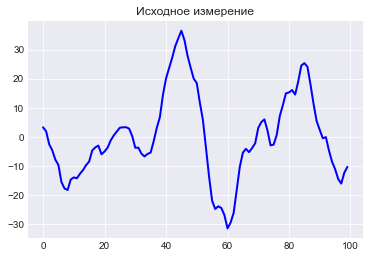

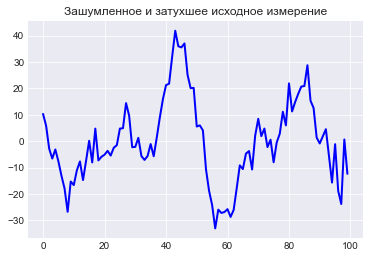

In [57]:
plt.plot([i for i in range(N)], x, \
                  **{'linewidth' : 2, 'color' : 'blue', 'label' : 'x'});
plt.title('Исходное измерение')
z = x + np.random.normal(0, 5, N)
plt.figure()
plt.plot([i for i in range(N)], z, \
                  **{'linewidth' : 2, 'color' : 'blue', 'label' : 'x'});
plt.title('Зашумленное и затухшее исходное измерение');

Создадим фильтр (одномерную свертку), через который пропустим "зашумленный" и эвлюционированный сигнал, который в теории должен "восстановить" (приблизить) его до исходного. 

- Я не уверен, какие фильтры лучше использовать, поэтому использовал пока что только один [фильтр для изображений (стр 46)](http://www.lib.uniyar.ac.ru/edocs/iuni/20060713.pdf), но в одномерном случае (для изображений при разных Q были разные фильтры, но здесь они почему-то не работают). + Различные виды padding не показали лучших результатов по сравнению с нулевым.
- Вместо этого я решил попробовать найти коэффициенты (ядро свертки) через нейронную сеть, и этот подход вылился в отдельный блок

[-1, 1]
214.56810108663822
[-1, 1]
208.83187421583415
[-1, 1]
208.83187421583415
[-1, 1]
208.83187421583415
[-1, 1]
208.83187421583415
Исходная sum of |z - x| =  361.7193173124071
sum of |result - x| =  208.83187421583415


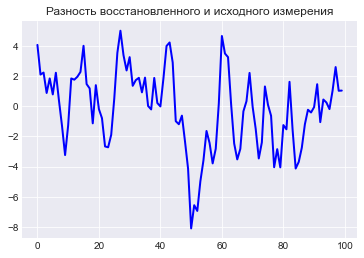

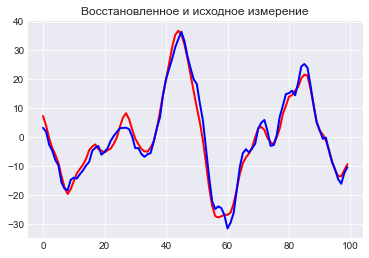

In [58]:
def applicate_filter(z):

    def measure_filter(z,al,ar,Q):
        N = np.size(z)
        M = int(N + ar-al);  # Dimension of observed signal y


        x_temp = np.zeros(M)
        res = np.zeros(N)
        z_rev = z.copy()
        if ar != 0 and al != 0:
            x_temp[-al:-ar] = z
            
            #  padding
            x_temp[:-al] = list(reversed(z_rev[:-al]))
            x_temp[-ar:] = list(reversed(z_rev[-ar:]))
        else:
            x_temp = z


        for i in range(N):
            res[i] = np.sum( x_temp[i:i+ar-al+1] ** (Q+1) ) / np.sum( x_temp[i:i+ar-al+1] ** Q)

        return res

    metric_min = 10**5
    Q = 0
    # Проведем несколько итераций
    for i in range(5):
        z1 = z
        if i >0:
            z1 = result

        # Выберем наилучший результат из всех имеющихся
        for al in range(-5,1): # Левая граница свертки
            for ar in range(0,6): # Правая граница свертки
                result_temp = measure_filter(z1,al,ar,Q)
                metric_temp = np.sum(np.abs(result_temp - x))
                if metric_min > metric_temp:
                    metric_min = metric_temp
                    result = result_temp
                    a_best = [al,ar]

        print(a_best)
        print(metric_min)
    return result


result = applicate_filter(z)
plt.figure()
plt.title('Разность восстановленного и исходного измерения')
plt.plot([i for i in range(N)], result-x, \
                  **{'linewidth' : 2, 'color' : 'blue', 'label' : 'x'});
plt.figure()
plt.title('Восстановленное и исходное измерение')
plt.plot([i for i in range(N)], result, \
                  **{'linewidth' : 2, 'color' : 'red', 'label' : 'x'});
plt.plot([i for i in range(N)], x, \
                  **{'linewidth' : 2, 'color' : 'blue', 'label' : 'x'});
print('Исходная sum of |z - x| = ',np.sum(np.abs(z-x)))
print('sum of |result - x| = ',np.sum(np.abs(result-x)))

Исходя из данной реализации при больших величинах дисперсии выигрыш получается в 1.5-2 раза. При небольших дисперсиях данный подход не улучшает оценку.

## Нейронная сеть для зашумленного измерения

In [131]:
import keras

### Восстановление сигнала из зашумленного
Попробуем обучить нейронную сеть находить оптимальные фильтры для зашумленного измерения

In [155]:
# Теплицева матрица
B = get_B(N)
# Размер батча с данными для одного значения sigma
batch_size = 256

# Инициализируем обучающую выборку
y_train = np.array([])
x_train = np.array([])

for _ in range(100): # Число генераций батчей с данными
    sigma = np.random.uniform(0.05,15,1)
    
    # Генерации измерений (обучающие выходы)
    y_temp, _, x0 = Xgeneration(N, B, batch_size)
    y_temp = y_temp.transpose()
    
    # Запись в массив обучающих таргетов
    if y_train.size == 0:
        y_train = y_temp
    else:
        y_train = np.vstack((y_train, y_temp))

    # Массив обучающих входов (случайных сигнал х + шум)
    x_temp = y_temp + np.random.normal(0, sigma,(batch_size,N))
    
    # Добавим значение sigma и мат ожидания к обучающим входам
    x_temp = np.append(x_temp, np.zeros((batch_size,1))+sigma, axis=1)
    x_temp = np.append(x_temp, x_temp[:,:-1].mean(axis=1).reshape(batch_size,1), axis=1)
    
    # Запись в массив обучающих входов
    if x_train.size == 0:
        x_train = x_temp
    else:
        x_train = np.vstack((x_train, x_temp))

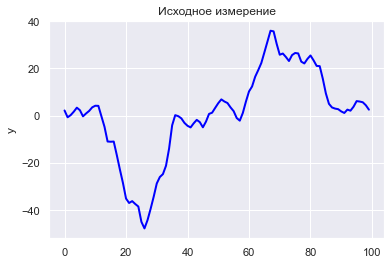

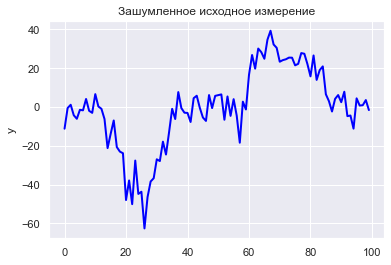

In [156]:
plt.title('Исходное измерение')
plt.ylabel('y')
plt.plot([i for i in range(N)], y_train[1,:], \
                  **{'linewidth' : 2, 'color' : 'blue', 'label' : 'x'});

plt.figure()
plt.title('Зашумленное исходное измерение')
plt.ylabel('y')
plt.plot([i for i in range(N)], x_train[1,:-2], \
                  **{'linewidth' : 2, 'color' : 'blue', 'label' : 'x'});

In [157]:
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

# Создадим простейшую модель нейронного обучения:
# Мы предполагаем, что некоторой одномерной конечной сверткой можно привести
# зашумленное измерение к исходному 
# (аналогичного вида свертка используется для получения 
# незашумленного измерения из исходного сигнала])
model = Sequential()
model.add(layers.Dense(y_train.shape[1], input_shape=(x_train.shape[1],)))
model.compile(optimizer='rmsprop',
              loss='mean_squared_error',
              metrics=['mse'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 100)               10300     
Total params: 10,300
Trainable params: 10,300
Non-trainable params: 0
_________________________________________________________________


In [158]:
# Обучим модель на малом числе эпох (у нас довольно много обучающих данных)
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)


Train on 20480 samples, validate on 5120 samples
Epoch 1/10
20480/20480 [==============================] - 1s 65us/step - loss: 94.1932 - mse: 94.1932 - val_loss: 21.0915 - val_mse: 21.0915
Epoch 2/10
20480/20480 [==============================] - 1s 60us/step - loss: 14.6783 - mse: 14.6783 - val_loss: 15.0957 - val_mse: 15.0957
Epoch 3/10
20480/20480 [==============================] - 1s 63us/step - loss: 13.3871 - mse: 13.3871 - val_loss: 14.9262 - val_mse: 14.9262
Epoch 4/10
20480/20480 [==============================] - 1s 70us/step - loss: 13.3694 - mse: 13.3694 - val_loss: 14.8777 - val_mse: 14.8777
Epoch 5/10
20480/20480 [==============================] - 1s 61us/step - loss: 13.3767 - mse: 13.3767 - val_loss: 14.8891 - val_mse: 14.8891
Epoch 6/10
20480/20480 [==============================] - 1s 62us/step - loss: 13.3673 - mse: 13.3673 - val_loss: 14.8873 - val_mse: 14.8873
Epoch 7/10
20480/20480 [==============================] - 1s 66us/step - loss: 13.3640 - mse: 13.3640 - v

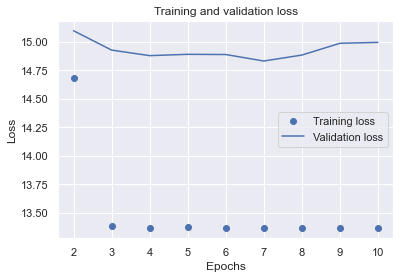

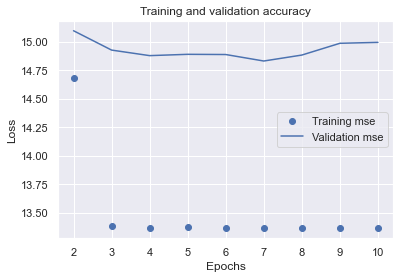

In [159]:
# Посмотрим на процесс обучения (много обучающих данных, поэтому быстрое обучение)
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs[1:], loss[1:], 'bo', label='Training loss')
plt.plot(epochs[1:], val_loss[1:], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.figure()
mse = history.history['mse']
val_mse = history.history['val_mse']

plt.plot(epochs[1:], mse[1:], 'bo', label='Training mse')
plt.plot(epochs[1:], val_mse[1:], 'b', label='Validation mse')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [163]:
# Сгенерируем тестовый сигнад, чтобы посмотреть на вид оценки
sigma = np.random.uniform(0.05,10,1)
sigma = 1
test_size = 1
y_test, _, x0 = Xgeneration(N, B, 1) 
y_test = y_test.transpose()

x_test = y_test + np.random.normal(0, sigma,(1,N))

x_test = np.append(x_test, np.zeros((test_size,1))+sigma, axis=1)
x_test = np.append(x_test, x_test[:,:-1].mean(axis=1).reshape(test_size,1), axis=1)

sum of |result - x| =  131.85976662639806


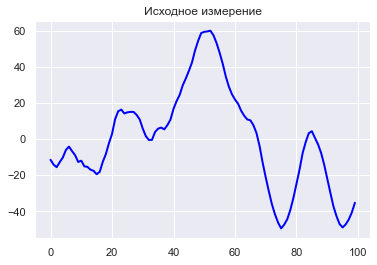

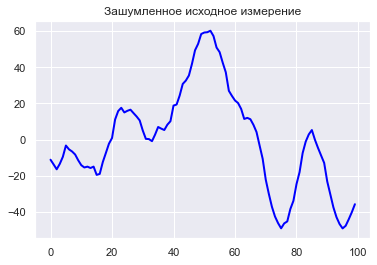

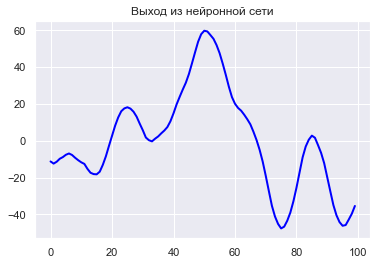

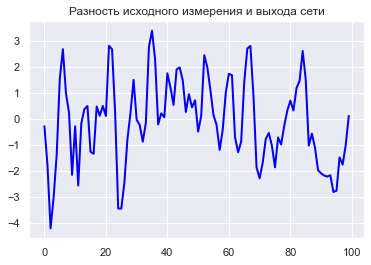

In [164]:
from keras import backend as K

inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
functor = K.function([inp, K.learning_phase()], outputs )   # evaluation function

layer_outs = functor([x_test, y_test])

plt.title('Исходное измерение')
plt.plot([i for i in range(N)], y_test, \
                  **{'linewidth' : 2, 'color' : 'blue', 'label' : 'x'});
plt.figure()
plt.title('Зашумленное исходное измерение')
plt.plot([i for i in range(N)], x_test[0,:-2], \
                  **{'linewidth' : 2, 'color' : 'blue', 'label' : 'x'});
plt.figure()
plt.title('Выход из нейронной сети')
plt.plot([i for i in range(N)], layer_outs[0][0,:], \
                  **{'linewidth' : 2, 'color' : 'blue', 'label' : 'x'});
plt.figure()
plt.title('Разность исходного измерения и выхода сети')
plt.plot([i for i in range(N)], y_test - layer_outs[0][0,:], \
                  **{'linewidth' : 2, 'color' : 'blue', 'label' : 'x'});
print('sum of |result - x| = ',np.sum(np.abs( y_test - layer_outs[0][0,:])))

In [ ]:
# Сохраним модель
#model.save('OE46_with_sigma_mse_5.h5')

### Здесь в дальнейшем можно бует сравнить модели

In [87]:
#model.load_weights('pre_trained_glove_model.h5')
#model.evaluate(x_test, y_test)

Так в рамках одной PSF матрица $R$ и $r$ одинаковые, то можно обучить нейроную сеть для каждого случая поотдельности